# Logistic Regression for Predicting Dengue Fever: Subgroup Assessment

**Abstract:** A logistic regression model was trained on tabular medical data (age, temperature, WBC exam score, Plt exam score) to predict whether or not patients had dengue fever. Datasets were split according to various features to assess the model's predictive stability. Dengue fever is a serious illness that is initially not easily detectable, and initial symptoms tend to be similar to those of the flu. The advantage of using logistic regression to predict the existence dengue fever in patients, as opposed to using other machine learning methods, is the method can be easily understood by doctors and is easily interpretable.

## Theory

### Logistic Regression

The logistic regression model takes real numbers as inputs and returns the probability those inputs corresponding to an output of 0 or 1 (or True or False) for a given output label. A probability p > 0.5 corresponds to a predicted output of 1, and p < 0.5 corresponds to an output of 0. In this case, the output indicates whether or not a given patient is predicted to have dengue.

The probability $p$ is calculated as shown:

$$p = \frac{1}{1 + e^{-x}}$$

Where $x$ is the set of all inputs, calculated from each input feature as follows:

$$x = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 \dots$$

Each $\beta$ is a coefficient determined my fitting inputs to outputs using training data and given training outputs. Once $\beta$ coefficients are determined from training data, the model can be used to predict outputs of validation and test set data using the formula for $p$.

In the case of this experiment, four features were used, with $x_1, x_2, x_3$ and $x_4$ corresponding to the features *age, temperature, WBC exam score,* and *Plt exam score.*

### Subgroups

#### n-Fold Cross Validation: Training Multiple Models

In n-fold cross validation, the overall dataset is split into equal parts for the purpose of training multiple models, such that all of the data is used at least once in a validation set. The confusion matrices (true negatives, false positives, false negatives, true positives) for each model are then added together to calculate the overall metrics of using logistic regression on the dataset.

For this experiment, 5-fold cross validation was performed. The dataset was split into five equal subsets (each 20% of original dataset). The subsets were grouped into five validation sets (20% of original dataset) and five training sets (80% of original dataset, i.e., original dataset minus validation set). Five logistic regression models were trained and then assessed with corresponding validation sets. The resulting five confusion matrices were summed, producing an overall confusion matrix that would be used to calculate overall metrics.

#### Validation Subgroup Analysis

The validation datasets of each model were split into multiple subgroups based on various features, *(Age, Gender, Epidemic periods, Body Temp, White Blood Cells, Platelet, Comorbidities, coming to ER)*, to assess stability of the model accross datasets. The subgroup confusion matrices were summed across multiple models, resulting in overall confusion matrices for each subgroup. Confusion matrices were then used to calculate overall metrics for each subgroup.

## Setup


This notebook was originally written with the following versions:

    python 3.7.4
    scikit-learn 0.20.4
    pandas 0.25.0
    numpy 1.16.4
    matplotlib 3.1.0
    scipy 1.3.1
    

In [1]:
# Check your versions
!python --version;
!pip freeze | grep scikit-learn;
!pip freeze | grep pandas;
!pip freeze | grep numpy;
!pip freeze | grep matplotlib;
!pip freeze | grep scipy;

Python 3.7.4
scikit-learn==0.20.4
pandas==0.25.0
msgpack-numpy==0.4.3.2
numpy==1.16.4
numpydoc==0.9.1
matplotlib==3.1.0
scipy==1.3.1


##### Prepare Notebook

In [2]:
# Jupyter Notebook Magic

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import Modules

import datetime
from pathlib import Path
import unittest

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

# My Own Modules
from pyfiles.autometrics import show_metrics, subgroup_analysis, conf_and_auc
import pyfiles.autometrics
# import pyfiles.df_converter

# Data Information

# filename = 'patient_year_vital_lab_exam_add-on_death_outcome_comorbidity_TCIC_dengue_suspected_bmi_ER_label_missing_mask.csv'
path = Path('../mydata')
filename='patients_cleaned.csv'

In [3]:
# View all CSV column names

# df = pd.read_csv(path/filename, low_memory=False)
# "', '".join(df.columns.tolist())

# Parameters

In [4]:
splits = 5 # number of folds for cross validation
recalls = [0.85,0.90,0.95] # sensitivities used for calculating results


# Imported columns from CSV
desired_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'Opd_Visit_Date',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

# Features used for training + dependent variable
train_cols = ['age','Temp','exam_WBC','exam_Plt','lab_result']


# Features used for creating validation subgroups (includes features from train_cols)
subgroup_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'week',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

# Columns to be dropped after creating validation subgroups
drop_cols = list(set(subgroup_cols) - set(train_cols))

## Data Preparation

### Convert CSV to Dataframe –> Randomize Dataframe –> Convert Categorical Values to Numeric Ones

In [5]:
# Read CSV with desired columns

# desired_cols defined in Parameters section
df = pd.read_csv(path/filename, usecols=desired_cols)


# Randomize data
df = df.iloc[np.random.permutation(len(df))]


# Convert Opd_Visit_Date to week of year format

if 'week' not in df.columns:
    week_numbers = [datetime.datetime.strptime(d, "%Y/%m/%d").isocalendar()[1] for d in df['Opd_Visit_Date']]
    df.insert(0, 'week', week_numbers)
    
if 'Opd_Visit_Date' in df.columns:
    df.drop(columns=['Opd_Visit_Date'],inplace=True)
    
    
# Convert 男 and 女 to 0 and 1 in column 'sex'

df_male_indx = df[df['sex']=='男']
df_female_indx = df[df['sex']=='女']

for i in df_male_indx.index.tolist():
    df.at[int(i),'sex'] = 0
    
for i in df_female_indx.index.tolist():
    df.at[int(i),'sex'] = 1

print('Size:',len(df))    
df.head()

Size: 4894


,week,sex,age,Temp,exam_Plt,exam_WBC,CKD,DM,CVA,Hypertension,Heart Disease,Cancer without Metastasis,Cancer with Metastasis,Severe Liver Disease,lab_result,ER
1700,37,0,32,38.8,197.0,3.0,False,False,False,True,False,False,False,False,True,True
681,36,0,62,39.4,206.0,5.3,True,False,False,False,False,False,False,False,True,False
2426,38,1,21,38.9,216.0,7.2,False,False,False,True,False,False,False,False,False,True
4113,42,0,41,39.4,232.0,8.3,False,False,False,False,False,False,False,True,True,True
1119,36,1,23,39.0,149.0,5.4,False,False,False,False,False,True,False,False,True,True


### Separate Dataframe into Subsets

In [6]:
dataframe = df

# Equal length subsets of original dataframe
len_df = len(dataframe)
cut_indices = [int(i*(1/splits)*len_df) for i in range(0,splits+1)]
cut_indices = zip(cut_indices[:-1], cut_indices[1:])
subsets = [dataframe[i:j] for i,j in cut_indices]

# print sizes
print('Dataframe', ' Sizes')
print('-'*28)
for i in range(splits):
    print(f'Subset {i+1}:  {len(subsets[i])} ({100*len(subsets[i])/len(dataframe):0.1f}%)')
print('-'*28)
print(f'Original:  {len(dataframe)} ({100*len(dataframe)/len(dataframe):0.1f}%)')

Dataframe  Sizes
----------------------------
Subset 1:  978 (20.0%)
Subset 2:  979 (20.0%)
Subset 3:  979 (20.0%)
Subset 4:  979 (20.0%)
Subset 5:  979 (20.0%)
----------------------------
Original:  4894 (100.0%)


### Build Training Sets from Subsets

In [7]:
trains = [pd.concat(subsets[1:], axis=0)]
for n in range(1,splits):
    trains += [pd.concat(subsets[:n]+subsets[n+1:], axis=0)] 

len(trains)


5

### Build Validation Subgroups

In [8]:
# Separate Dataframe into Subgroups

frames = [] # temporarily stores dataframes

for modelnum in range(1,splits+1):

    dataframe = subsets[modelnum-1] # validation set

    # age
    df_age_under_18 = dataframe[dataframe['age']<18]
    df_age_18_to_65 = dataframe[(dataframe['age']>=18) & (dataframe['age']<65)]
    df_age_over_eq_65 = dataframe[dataframe['age']>=65]

    # sex
    df_female = dataframe[dataframe['sex']==1]
    df_male = dataframe[dataframe['sex']==0]

    # week
    df_wks_35 = dataframe[dataframe['week']<=35]
    df_wks_35_to_40 = dataframe[(dataframe['week']>35) & (dataframe['week']<=40)]
    df_wks_over_40 = dataframe[dataframe['week']>40]

    # Temp
    df_temp_over_38 = dataframe[dataframe['Temp']>38]
    df_temp_under_eq_38 = dataframe[dataframe['Temp']<=38]

    # exam_WBC
    df_wbc_low = dataframe[dataframe['exam_WBC']<3.2]
    df_wbc_normal = dataframe[(dataframe['exam_WBC']>=3.2) & (dataframe['exam_WBC']<10)]
    df_wbc_high = dataframe[dataframe['exam_WBC']>10]

    # exam_Plt
    df_plt_low = dataframe[dataframe['exam_Plt']<100]
    df_plt_high = dataframe[dataframe['exam_Plt']>=100]

    # Comorbidities
    df_heart_disease = dataframe[dataframe['Heart Disease']==True]
    df_cva = dataframe[dataframe['CVA']==True]
    df_ckd = dataframe[dataframe['CKD']==True]
    df_liver = dataframe[dataframe['Severe Liver Disease']==True]
    df_dm = dataframe[dataframe['DM']==True]
    df_hypertension = dataframe[dataframe['Hypertension']==True]


    df_cancer1 = dataframe[(dataframe['Cancer with Metastasis']==True)]
    df_cancer2 = dataframe[(dataframe['Cancer without Metastasis']==True)]
    df_cancer = pd.concat([df_cancer1, df_cancer2], axis=0)

    df_er = dataframe[dataframe['ER']==True]

    frame = [df_age_under_18, df_age_18_to_65, df_age_over_eq_65, df_female, df_male, df_wks_35, df_wks_35_to_40, 
          df_wks_over_40, df_temp_over_38, df_temp_under_eq_38, df_wbc_low, df_wbc_normal, df_wbc_high, 
          df_plt_low, df_plt_high, df_heart_disease, df_cva, df_ckd, df_liver, df_dm, df_hypertension, 
          df_cancer, df_er]

    dfs_names = ['df_age_under_18', 'df_age_18_to_65', 'df_age_over_eq_65', 'df_female', 'df_male', 'df_wks_35', 'df_wks_35_to_40', 
          'df_wks_over_40', 'df_temp_over_38', 'df_temp_under_eq_38', 'df_wbc_low', 'df_wbc_normal', 'df_wbc_high', 
          'df_plt_low', 'df_plt_high', 'df_heart_disease', 'df_cva', 'df_ckd', 'df_liver', 'df_dm', 'df_hypertension', 
          'df_cancer', 'df_er']

    dfs = frame # because of older code... (technical debt)

    # Display Subgroup Sizes

    print("Dataframes (Model "+str(modelnum)+')'," "*(20-len('dataframes (Model n)')),"| Length", ' ',"| Percent Length")
    print("-"*50)
    length = 0
    for i in range(len(dfs)):
        print(dfs_names[i],' '*(20-len(dfs_names[i])),'|',len(dfs[i]),' '*(7-len(str(len(dfs[i])))),f'| {100*len(dfs[i])/len(dataframe):0.2f}%')
        length += len(dfs[i])
    print('-'*42)
    print('valid_df '+str(modelnum),' '*(20-len('valid_df 1')), '|', len(dataframe),' '*2 ,f' | 100%') 
    print('\n'*2)

    frames += [frame]
    
# RESET DFS

dfs = frames


Dataframes (Model 1)  | Length   | Percent Length
--------------------------------------------------
df_age_under_18       | 70       | 7.16%
df_age_18_to_65       | 682      | 69.73%
df_age_over_eq_65     | 226      | 23.11%
df_female             | 473      | 48.36%
df_male               | 505      | 51.64%
df_wks_35             | 130      | 13.29%
df_wks_35_to_40       | 591      | 60.43%
df_wks_over_40        | 257      | 26.28%
df_temp_over_38       | 557      | 56.95%
df_temp_under_eq_38   | 421      | 43.05%
df_wbc_low            | 145      | 14.83%
df_wbc_normal         | 657      | 67.18%
df_wbc_high           | 175      | 17.89%
df_plt_low            | 160      | 16.36%
df_plt_high           | 818      | 83.64%
df_heart_disease      | 112      | 11.45%
df_cva                | 45       | 4.60%
df_ckd                | 205      | 20.96%
df_liver              | 87       | 8.90%
df_dm                 | 168      | 17.18%
df_hypertension       | 198      | 20.25%
df_cancer           

In [9]:
# show a random subgroup in dfs[0]
ri = np.random.randint(low=0,high=len(dfs[0]))
print(dfs_names[ri])
dfs[0][ri].head()

df_temp_over_38


,week,sex,age,Temp,exam_Plt,exam_WBC,CKD,DM,CVA,Hypertension,Heart Disease,Cancer without Metastasis,Cancer with Metastasis,Severe Liver Disease,lab_result,ER
1700,37,0,32,38.8,197.0,3.0,False,False,False,True,False,False,False,False,True,True
681,36,0,62,39.4,206.0,5.3,True,False,False,False,False,False,False,False,True,False
2426,38,1,21,38.9,216.0,7.2,False,False,False,True,False,False,False,False,False,True
4113,42,0,41,39.4,232.0,8.3,False,False,False,False,False,False,False,True,True,True
1119,36,1,23,39.0,149.0,5.4,False,False,False,False,False,True,False,False,True,True


### Remove Unused Features for All Models

In [10]:
# drop_cols defined in Parameters section

for model_indx in range(len(dfs)):
    dataframes = dfs[model_indx]
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]
    
    
    # Remove columns of unused features in validation subgroups
    for i in range(len(dataframes)):
        if drop_cols[0] in dataframes[i].columns:
            dataframes[i].drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in training dataset
    if drop_cols[0] in train_df.columns:
        train_df.drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in full validation dataset
    if drop_cols[0] in valid_df.columns:
        valid_df.drop(columns=drop_cols,inplace=True)

    print("(ignore the pandas warning)")
        

(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)


/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# show a random subgroup in dfs[0]
# ri = np.random.randint(low=0,high=len(dfs1))
print(dfs_names[ri])
dfs[0][ri].head()

df_temp_over_38


,age,Temp,exam_Plt,exam_WBC,lab_result
1700,32,38.8,197.0,3.0,True
681,62,39.4,206.0,5.3,True
2426,21,38.9,216.0,7.2,False
4113,41,39.4,232.0,8.3,True
1119,23,39.0,149.0,5.4,True


### Remove NaN Values for All Models

The logistic regression model cannot do anything with NaN inputs. Two options for dealing with this are drop all data with NaN values, or to transform all NaN inputs into the median values of their corresponding columns.

In [12]:
for model_indx in range(len(dfs)):
    dataframes = dfs[model_indx]
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]

    # Option A: Drop NaNs

    # Remove NaN values in Validation Subgroups
    print('-'*60)
    print("Dataframes (Model "+str(model_indx+1)+')'," "*(20-len('dataframes (model n)')),"| Before","| After   |", 'NaNs Removed')
    print("-"*60)
    for i in range(len(dataframes)):
        before = len(dataframes[i])
        dataframes[i].dropna(how='any',inplace=True)
        after = len(dataframes[i])
        print(dfs_names[i],' '*(20-len(dfs_names[i])),'|',before,' '*(5-len(str(before))),'|   ',after,' '*(3-len(str(after))),'|    ', before-after)

    # Remove NaN values in Training Dataset
    before = len(train_df)
    train_df.dropna(how='any',inplace=True)
    after = len(train_df)
    print('train_df',' '*(20-len('train_df')),'|',before,' '*(5-len(str(before))),'|  ',after,' '*(3-len(str(after))),'|    ', before-after)

    # Remove NaN values in Full Validation Dataset
    before = len(valid_df)
    valid_df.dropna(how='any',inplace=True)
    after = len(valid_df)
    print('valid_df',' '*(20-len('valid_df')),'|',before,' '*(5-len(str(before))),'|  ',after,' '*(3-len(str(after))),'|    ', before-after)

    print('-'*60)
    print('\n'*2)

    # Option B: Convert NaNs to median values

    # for i in range(len(dataframes)):
    #     dataframes[i] = NaN_converter(dataframes[i])

    # train_df = NaN_converter(train_df)
    # valid_df = NaN_converter(valid_df)

------------------------------------------------------------
Dataframes (Model 1)  | Before | After   | NaNs Removed
------------------------------------------------------------
df_age_under_18       | 70     |    70   |     0
df_age_18_to_65       | 682    |    682  |     0
df_age_over_eq_65     | 226    |    226  |     0
df_female             | 473    |    473  |     0
df_male               | 505    |    505  |     0
df_wks_35             | 130    |    130  |     0
df_wks_35_to_40       | 591    |    591  |     0
df_wks_over_40        | 257    |    257  |     0
df_temp_over_38       | 557    |    557  |     0
df_temp_under_eq_38   | 421    |    421  |     0
df_wbc_low            | 145    |    145  |     0
df_wbc_normal         | 657    |    657  |     0
df_wbc_high           | 175    |    175  |     0
df_plt_low            | 160    |    160  |     0
df_plt_high           | 818    |    818  |     0
df_heart_disease      | 112    |    112  |     0
df_cva                | 45     |    45

/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


df_age_18_to_65       | 646    |    646  |     0
df_age_over_eq_65     | 268    |    268  |     0
df_female             | 487    |    487  |     0
df_male               | 492    |    492  |     0
df_wks_35             | 123    |    123  |     0
df_wks_35_to_40       | 594    |    594  |     0
df_wks_over_40        | 262    |    262  |     0
df_temp_over_38       | 572    |    572  |     0
df_temp_under_eq_38   | 407    |    407  |     0
df_wbc_low            | 140    |    140  |     0
df_wbc_normal         | 679    |    679  |     0
df_wbc_high           | 159    |    159  |     0
df_plt_low            | 152    |    152  |     0
df_plt_high           | 827    |    827  |     0
df_heart_disease      | 120    |    120  |     0
df_cva                | 56     |    56   |     0
df_ckd                | 233    |    233  |     0
df_liver              | 95     |    95   |     0
df_dm                 | 177    |    177  |     0
df_hypertension       | 179    |    179  |     0
df_cancer           

## Training

In [13]:
model_classifiers = []
model_preds = []
model_scores = []
model_valid_Ys = []
for model_indx in range(len(dfs)):
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]

    # MORE DATA PREPARATION
    
    # Separate inputs (X) from outputs (Y)
    train_X = train_df.loc[:,train_df.columns != 'lab_result']
    train_Y = train_df.loc[:,train_df.columns == 'lab_result']
    valid_X = valid_df.loc[:,valid_df.columns != 'lab_result']
    valid_Y = valid_df.loc[:,valid_df.columns == 'lab_result']

    # Convert to numpy arrays
    train_X = train_X.to_numpy('float64')
    train_Y = train_Y.to_numpy('float64').flatten()
    valid_X = valid_X.to_numpy('float64')
    valid_Y = valid_Y.to_numpy('float64').flatten()
    
    model_valid_Ys += [valid_Y] # save for later
    
    # TRAIN WITH CHOSEN SOLVER
    
    solver = 'lbfgs'

    print(f'Model {model_indx+1}')
    print("Solver: ", solver)

    clf = LogisticRegression(solver=solver,
                                    penalty='l2', class_weight={0:1, 1:1},
                                    max_iter=400)
    clf.fit(train_X, train_Y)
    Y_pred = clf.predict_proba(valid_X)[:,1]
    score = clf.score(valid_X,valid_Y)
    print("Validation Score: {}\n".format(score))
    model_classifiers += [clf]
    model_preds += [Y_pred]

    model_scores += [score]

Model 1
Solver:  lbfgs
Validation Score: 0.8128834355828221

Model 2
Solver:  lbfgs
Validation Score: 0.7763023493360572

Model 3
Solver:  lbfgs
Validation Score: 0.7916241062308478

Model 4
Solver:  lbfgs
Validation Score: 0.804902962206333

Model 5
Solver:  lbfgs
Validation Score: 0.8008171603677222



## Overall Metrics

In [14]:
# Overall Results

# recalls defined in Parameters section

# For each recall
    # Get results for overall validation set for each model
    # Sum confusion matrices across models
    # return metrics for overall results of all models

for rec in recalls:
    confs = []
    for model_indx in range(len(dfs)):
        result_prob = model_preds[model_indx]
        label = model_valid_Ys[model_indx]
        recall = rec

        conf, roc_auc = conf_and_auc(label, result_prob, recall)

        confs += [conf]

    conf = sum(confs)
    results = pyfiles.autometrics.return_metrics(conf,roc_auc)
    result_names = ['roc_auc', 'PPV', 'NPV', 'F1', 'accuracy', 'sensitivity', 'specificity', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'length']

    meh = list(zip(result_names, results))
    print('OVERALL RESULTS',' '*5,f'(Recall: {recall})')
    print('-'*35)
    for i in range(len(meh)):
        print(f'{meh[i][0]}', ' '*(15-len(str(result_names[i]))) ,f'{meh[i][1]}')
    print('\n'*2)


OVERALL RESULTS       (Recall: 0.85)
-----------------------------------
roc_auc          0.835890799285142
PPV              0.8159869494290375
NPV              0.7588846364133406
F1               0.8326951889462294
accuracy         0.7946465059256232
sensitivity      0.8501019714479946
specificity      0.7110655737704918
odds_ratio       13.956787443109631
TN               1388
FP               564
FN               441
TP               2501
length           4894



OVERALL RESULTS       (Recall: 0.9)
-----------------------------------
roc_auc          0.835890799285142
PPV              0.7906837862048373
NPV              0.8097087378640777
F1               0.8418375457002066
accuracy         0.796689824274622
sensitivity      0.9000679809653297
specificity      0.6408811475409836
odds_ratio       16.073481032926722
TN               1251
FP               701
FN               294
TP               2648
length           4894



OVERALL RESULTS       (Recall: 0.95)
-----------------------

#### ROC Curves for Each Model

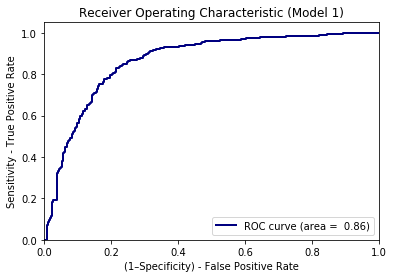

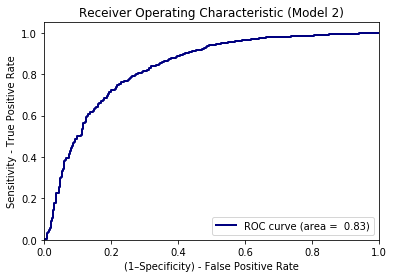

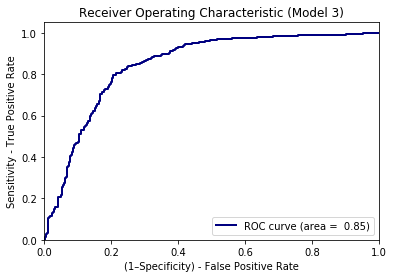

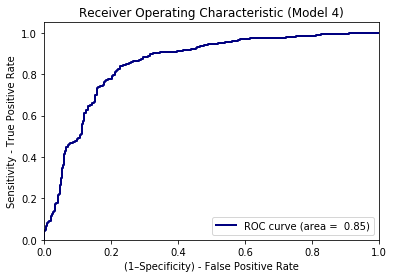

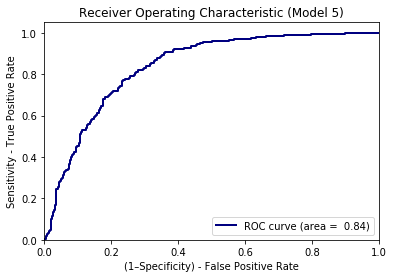

In [15]:
# show ROC curve for each model

tprs = []
fprs = []
tprs_interp = []
base_fpr = np.linspace(0, 1, 101)

for model_indx in range(len(dfs)):
    result_prob = model_preds[model_indx]
    label = model_valid_Ys[model_indx]

    score = np.array([result_prob[j] for j in range(result_prob.shape[0])])
    fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC Curve for Each Model
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='navy',
             lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')
    # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('(1–Specificity) - False Positive Rate')
    plt.ylabel('Sensitivity - True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Model {model_indx+1})')
    plt.legend(loc="lower right")
    plt.show()
    
    # Store fpr and tpr for combined plot
#     plt.plot(fpr, tpr, 'b', alpha=0.15)
    tprs += [tpr]
    fprs += [fpr]
    tpr[0] = 0.0
    tprs_interp += [interp(base_fpr, fpr, tpr)]
    
    
    

#### Combined ROC Curve

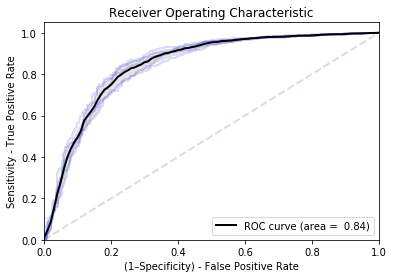

In [16]:
# Create and Save Overall ROC Plot

path = Path('../mydata/myoutput')
img_filename = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_ROC.png'

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
# plt.axes().set_aspect('equal', 'datalim')

for model_indx in range(len(dfs)):
    fpr = fprs[model_indx]
    tpr = tprs[model_indx]
    plt.plot(fpr, tpr, color='blue',lw=lw, alpha=0.14)

    
# THE MEAN COULD NOT BE CALCULATED AS EACH TPR HAS A DIFFERENT SHAPE
    
mean_tprs = np.array(tprs_interp).mean(axis=0)
std = np.array(tprs_interp).std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'black', lw=2,label=f'ROC curve (area = {roc_auc: 0.2f})')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)


plt.xlabel('(1–Specificity) - False Positive Rate')
plt.ylabel('Sensitivity - True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# save file
plt.savefig(path/img_filename, bbox_inches='tight')

plt.show()

## Subgroup Analysis

In [17]:
# Performs subgroup analysis for each model at given sensitivities (recalls)
# Then calculates overall metrics for each subgroup

# recalls defined in Parameters section

# For each recall, 
#     for each model's validation set
#         get confusion matrix of subgroups
#     sum confusion matrices across models for each subgroup
#     calculate metrics from summed confusion matrices
#     store metrics into a dataframe
#     write to csv file


for rec in recalls:    
    confs = 0
    for model_indx in range(len(dfs)):
        dataframes = dfs[model_indx] # subgroups for each model
        Y_pred = model_preds[model_indx]
        valid_Y = model_valid_Ys[model_indx] 
        clf = model_classifiers[model_indx]
        valid_df = subsets[model_indx]

        analysis = subgroup_analysis(clf=clf, dfs=dataframes+[valid_df], dfs_names=dfs_names+['valid_df (overall)'], dep_var='lab_result',recalls=[rec])
#         # Note: first index of analysis is recall value index
#         # second index of analysis is 0 for recall value, 1 for data corresponding to that recall

#         # Example:
#         # if recalls = [0.85,0.90,0.95]
#         # then, analysis[0][0] returns 0.85
#         # analysis[0][1] is the results for recall = 0.85, in dataframe format
#         # analysis[1][0] returns 0.90, analysis[1][1] returns results for recall=0.90, and so forth


        # Sum confusion matrices across models and store roc_auc
        rocs = analysis[0][1]['roc_auc'].values
        confs += analysis[0][1].to_numpy()[:,-4:]

        
    # Calculate Overall Metrics for Each Subgroup
    
    rocs = rocs.tolist()
    confs = confs.tolist()

    names = dfs_names+['valid_df (overall)']
    cols = ['dataframe', 'roc_auc', 'PPV', 'NPV', 'F1', 'accuracy', 'sensitivity', 'specificity', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'size']

    results = []
    for i in range(len(names)):
        conf = [confs[i][0],confs[i][1],confs[i][2],confs[i][3]]
        res = pyfiles.autometrics.calc_metrics(confs[i][0],confs[i][1],confs[i][2],confs[i][3], rocs[i])
        results += [[names[i]] + res]

    final_subgroup_results = pd.DataFrame(results,columns=cols)

    to_file = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'
    path = Path('../mydata/myoutput')

    final_subgroup_results.to_csv(path/to_file, index=None)


## Results

#### Metrics

In [18]:
path = Path('../mydata/myoutput')

In [19]:
rec = 0.85

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

,dataframe,roc_auc,PPV,NPV,F1,accuracy,sensitivity,specificity,odds_ratio,TN,FP,FN,TP,size
0,df_age_under_18,0.846154,0.767677,0.861635,0.817204,0.809524,0.873563,0.748634,20.577075,137,46,22,152,357
1,df_age_18_to_65,0.800045,0.796422,0.810970,0.836253,0.801721,0.880278,0.695369,16.783668,961,421,224,1647,3253
2,df_age_over_eq_65,0.641520,0.801170,0.709302,0.854914,0.782710,0.916388,0.472868,9.831765,183,204,75,822,1284
3,df_female,0.783903,0.800948,0.834247,0.855425,0.811001,0.917855,0.644444,20.252066,609,336,121,1352,2418
4,df_male,0.757005,0.791147,0.770642,0.825903,0.783926,0.863853,0.667329,12.727881,672,335,200,1269,2476
5,df_wks_35,0.742234,0.847107,0.741007,0.881720,0.823435,0.919283,0.581921,15.852102,103,74,36,410,623
6,df_wks_35_to_40,0.772812,0.827035,0.780488,0.858220,0.812438,0.891850,0.673376,17.000934,736,357,207,1707,3007
7,df_wks_over_40,0.771216,0.677419,0.850000,0.760181,0.748418,0.865979,0.648094,11.900000,442,240,78,504,1264
8,df_temp_over_38,0.738600,0.811682,0.761024,0.858838,0.799156,0.911811,0.570362,13.725851,535,403,168,1737,2843
9,df_temp_under_eq_38,0.801350,0.767361,0.829811,0.807675,0.794734,0.852459,0.735700,16.082919,746,268,153,884,2051


In [20]:
rec = 0.9

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

,dataframe,roc_auc,PPV,NPV,F1,accuracy,sensitivity,specificity,odds_ratio,TN,FP,FN,TP,size
0,df_age_under_18,0.846154,0.672269,0.882353,0.776699,0.742297,0.919540,0.573770,15.384615,105,78,14,160,357
1,df_age_18_to_65,0.800045,0.796422,0.810970,0.836253,0.801721,0.880278,0.695369,16.783668,961,421,224,1647,3253
2,df_age_over_eq_65,0.641520,0.801170,0.709302,0.854914,0.782710,0.916388,0.472868,9.831765,183,204,75,822,1284
3,df_female,0.783903,0.800948,0.834247,0.855425,0.811001,0.917855,0.644444,20.252066,609,336,121,1352,2418
4,df_male,0.757005,0.791147,0.770642,0.825903,0.783926,0.863853,0.667329,12.727881,672,335,200,1269,2476
5,df_wks_35,0.742234,0.847107,0.741007,0.881720,0.823435,0.919283,0.581921,15.852102,103,74,36,410,623
6,df_wks_35_to_40,0.772812,0.827035,0.780488,0.858220,0.812438,0.891850,0.673376,17.000934,736,357,207,1707,3007
7,df_wks_over_40,0.771216,0.677419,0.850000,0.760181,0.748418,0.865979,0.648094,11.900000,442,240,78,504,1264
8,df_temp_over_38,0.738600,0.811682,0.761024,0.858838,0.799156,0.911811,0.570362,13.725851,535,403,168,1737,2843
9,df_temp_under_eq_38,0.801350,0.767361,0.829811,0.807675,0.794734,0.852459,0.735700,16.082919,746,268,153,884,2051


In [21]:
rec = 0.95

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

,dataframe,roc_auc,PPV,NPV,F1,accuracy,sensitivity,specificity,odds_ratio,TN,FP,FN,TP,size
0,df_age_under_18,0.846154,0.608856,0.895349,0.741573,0.677871,0.948276,0.420765,13.317610,77,106,9,165,357
1,df_age_18_to_65,0.800045,0.607557,0.838983,0.750000,0.624347,0.979690,0.143271,8.066634,198,1184,38,1833,3253
2,df_age_over_eq_65,0.641520,0.752406,0.737589,0.843137,0.750779,0.958751,0.268734,8.541687,104,283,37,860,1284
3,df_female,0.783903,0.800948,0.834247,0.855425,0.811001,0.917855,0.644444,20.252066,609,336,121,1352,2418
4,df_male,0.757005,0.593296,0.000000,0.744740,0.593296,1.000000,0.000000,0.000000,0,1007,0,1469,2476
5,df_wks_35,0.742234,0.783883,0.766234,0.862903,0.781701,0.959641,0.333333,11.888889,59,118,18,428,623
6,df_wks_35_to_40,0.772812,0.697383,0.797297,0.808174,0.709677,0.960815,0.269899,9.064411,295,798,75,1839,3007
7,df_wks_over_40,0.771216,0.460443,0.000000,0.630553,0.460443,1.000000,0.000000,0.000000,0,682,0,582,1264
8,df_temp_over_38,0.738600,0.776419,0.770344,0.847676,0.775237,0.933333,0.454158,11.648438,426,512,127,1778,2843
9,df_temp_under_eq_38,0.801350,0.505607,0.000000,0.671632,0.505607,1.000000,0.000000,0.000000,0,1014,0,1037,2051


#### ROC Curve

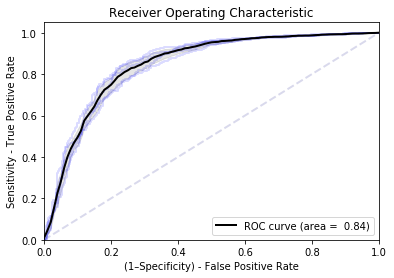

In [22]:
from PIL import Image
img_filename = f'logistic_regression_dengue_subgroup_analysis_{splits}_fold_ROC.png'

Image.open(path/img_filename)

&nbsp;

&nbsp;

## Conclusion

# &nbsp; 

## (scratchwork)

In [24]:
assert False

AssertionError: 

In [ ]:
type(tprs[0].shape)

In [ ]:
s = min([i.size for i in tprs])
# s = min(s,min([i.size for i in fprs]))
s = 101
tprs = np.array([i[:s] for i in tprs])
fprs = np.array([i[:s] for i in fprs])

In [ ]:
np.array(tprs).shape

In [ ]:
base_fpr.size

# &nbsp; 